# Anomaly Detection

In this notebook we finally perform our anomaly detection. We perform this in 6 steps:
1. Create a data frame for each individual username showing authentication types for 8/24 hours of each day
2. Use EDA, Isolation Forest's, Local Outlier Factor and other models to find 'normal' days or 'normal' usernames to allow us to train th CP_APR model
3. Train the CP_APR model with the data we've identified in step 2
4. Run the trained CP_APR model on the other data to identify anomalies in the 'test' data
5. Use a function to return the anomalous entry from the original data frame based on the output of the CP_APR function
6. Create a new data frame of anomalies

Finally, we may verify this process through other means such as HTM studio for a subset or other anomaly detection techniques. We may also use the original red team authentication data to determine whether the events given there were picked up by the CP_APR method.

First we import our libraries that we need.

In [1]:
from pyCP_APR import CP_APR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import os.path
import gzip
import shutil
import datetime
import networkx as nx
import pickle
from scipy import stats
from scipy import sparse
import bz2
import random
import regex as re
from tqdm import tqdm
import scipy

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tqdm.keras import TqdmCallback

We want to create reproducibility for our neural networks and doing the following permits this.

In [2]:
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### Original Data

Now we import the original data.

In [3]:
try:
    print('Attempting to read entire data set.')
    authentication_data = pd.read_csv('../Data/Authentication data.gz', compression='gzip', index_col = 0)
    process_data = pd.read_csv('../Data/Process data.gz', compression='gzip', index_col = 0)
except:
    clear_output()
    print('Unable to read entire data set, reading from original files.')
    rootdir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls'
    unzippeddir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls/Unzipped'
    frames = []

    count = 0
    
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file[-3:] == '.gz':
                filedir = rootdir + '/' + file
                with gzip.open(filedir) as f:
                    df = pd.read_csv(filedir, header=None)
                    frames.append(df)
                if 'authentications' in str(file):
                    count = count + len(df)
    
    df = pd.concat(frames)

    authentication_data = df[:count]
    authentication_data.columns = ['UserName', 'SrcDevice','DstDevice', 'Authent Type', 'Failure', 'DailyCount']

    process_data = df[count:]
    process_data = process_data[[0,1,2,3,4]]
    process_data.columns = ['UserName', 'Device', 'ProcessName', 'ParentProcessName', 'DailyCount']

    authentication_data.to_csv('../Data/Authentication data.gz', header=True, compression='gzip')
    process_data.to_csv('../Data/Process data.gz', header=True, compression='gzip')

Attempting to read entire data set.


C:\Users\corri\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
authentication_data[authentication_data['UserName'] == 'User035855']

,UserName,SrcDevice,DstDevice,Authent Type,Failure,DailyCount
0,User035855,Comp808475,Comp081330,TGS,0,17.0
6003,User035855,Comp808475,Comp081330,NetworkLogon,0,177.0
7915,User035855,Comp808475,Comp370444,NetworkLogon,0,11.0
20590,User035855,Comp808475,ActiveDirectory,NetworkLogon,0,105.0
21655,User035855,Comp808475,Comp004340,TGS,0,1.0
...,...,...,...,...,...,...
126274,User035855,Comp808475,ActiveDirectory,TGS,0,31.0
133464,User035855,Comp808475,Comp808475,TGS,0,7.0
138213,User035855,Comp808475,Comp253429,TGS,0,1.0
140361,User035855,Comp808475,Comp546675,TGS,0,2.0


In [5]:
authentication_data['Authent Type'].unique()

array(['TGS', 'NetworkLogon', 'TGT', 'WorkstationLock',
       'WorkstationUnlock', 'ScreensaverInvoked', 'InteractiveLogon',
       'ScreensaverDismissed', 'Service', 'Batch', 'CachedInteractive',
       'RemoteInteractive', 'CachedRemoteInteractive'], dtype=object)

### Other required data

#### Possible Username Lists

We need a list of usernames we'll consider for training/testing. Currently at the beginning of all this we will consider all usernames for both training and testing and reduce this as we go.

In [6]:
train_users = list(authentication_data['UserName'].unique())
test_users = list(authentication_data['UserName'].unique())

In [7]:
len(train_users)

28815

#### Authentication Red Team Usernames

In [8]:
rt_usernames = list(pd.read_csv('../Data/AuthUserNames.txt', header=None)[0])

#### Authentication Types

We'll need a dictionary of authentication types for later use.

In [9]:
a_t = list(authentication_data['Authent Type'].unique())
AT_dict = { i : a_t[i] for i in range(0, len(a_t) ) }

#### Authentication Day Starts

The below code defines the indices where each day begins in the authentiation data.

In [10]:
auth_index_list = authentication_data.index.tolist()
auth_start_days = [i for i, e in enumerate(auth_index_list) if e == 0]
auth_start_days.append(len(authentication_data))

### Step 1: DataFrame Creation

This first function is used to split a data frame into equal chunks. Since we need to split each day into 8/24 hours we use this function to split into equal time periods - this may not be perfectly representitive of the actual hour split but should be a good estimate since we don't have the original time stamps.

In [11]:
def split_dataframe(df,n): 
    chunks = list()
    chunk_size = int(np.round(df.shape[0]/n))
    num_chunks = n
    for i in range(num_chunks):
        if i != num_chunks-1:
            chunks.append(df[i*chunk_size:(i+1)*chunk_size])
        else:
            chunks.append(df[i*chunk_size:])
    return chunks

This function creates the required data frames. It takes as input a username and a split by number (8/24) and returns a data frame of the user's authentiation events split by type over 90 days, split by 8/24 hours.

In [12]:
def auth_type_un_df(user,n):
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n
    auth_type_dict = {}
    
    for i in range(len(auth_start_days)-1):
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                auth_type_data = data[data['UserName'] == user].groupby('Authent Type')['DailyCount'].sum()
                auth_type_dict[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())
    
    auth_type_df = pd.DataFrame(data=auth_type_dict,index = list(authentication_data['Authent Type'].unique()))
    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    return auth_type_df

This function creates the inputs for our CP_APR model. We pass a list of usernames to the function and it returns the set of co-ordinate tuples (i,j,e) where we have non-zero entries in our data matrices, along with the corresponding values for that matrix. i is the row of the matrix i.e. time, j is the column i.e. authentication type and e is the username number. We can instead pass a single username which would return this for just one user but this is optimised to run for all users when required.

In [ ]:
# def sparse_df(usernamelist,n):
    
#     coords = []
#     vals_list = []
    
#     for e,user in enumerate(usernamelist):
#         df = auth_type_un_df(user,n)
    
#         s = sparse.coo_matrix(df)
#         co = [[s.row[i],s.col[i],e] for i in range(len(s.row))]
#         vals = s.data
        
#         coords.append(co)
#         vals_list.append(vals)
    
#     coords = np.array([item for sublist in coords for item in sublist])
#     vals_list = np.array([item for sublist in vals_list for item in sublist])
    
#     return vals_list, coords

# the function above does this for a list of usernames - doesn't work atm so needs fixing but the below does what we want for a single username
def sparse_df(username,n):
    
    df = auth_type_un_df(username,n)

    s = sparse.coo_matrix(df)
    co = [[s.row[i],s.col[i],1] for i in range(len(s.row))]
    vals = s.data
    
    return vals, co

In [ ]:
# stime = datetime.datetime.now()

# n=10
# for i in range(n):
#     vals,co = sparse_df(train_users[i],24)

# etime = datetime.datetime.now()

# print('Time taken for {} iterations: {}.'.format(n,etime-stime))

In [ ]:
# stime = datetime.datetime.now()

# n=10
# for i in range(n):
#     vals,co = sparse_df(train_users[i],24)

# etime = datetime.datetime.now()

# print('Time taken for {} iterations: {}.'.format(n,etime-stime))

So we take roughly 4 seconds to compute a single username - doing this for 28,815 usernames would take $28,815 * \frac{4}{86400} = 1.3 $ days. Lets rewrite this with parallelisation.

In [ ]:
#%run -i SparseDataFrameCreation.py 10

In [ ]:
#%run -i SparseDataFrameCreation.py 100

We see speed improvements for large numbers of usernames but not for small ones.

#### Examples

In [ ]:
# Below is an example of a full matrix of the data we're considering called on a single username over 24 hours
#auth_type_un_df(train_users[0],24)

From the above we see that we obtain a data set of each day split into 24 hours. Each column represents an authentication type and non-zero entries represent an authentication event in that time period.

In [ ]:
# Below is an example of the sparse matrix representation we'll pass to the model - creates a big list so is commented but feel free to uncomment
# sparse_df(train_users[1000],24)

The first list is the non-zero values in the matrix and the second list is the list of co-ordinates where those non-zero values occur.

### Step 2: Determining Training Data

Days 1-56, and 83-90 are normal activity and therefore are training data whereas days 57-82 contain red team data.

In [ ]:
def scaled_iso_lof(data,plot=False,c='auto'):
    
    # scaling
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data))
    
    # isolation forest predictions
    if_model = IsolationForest(contamination=c)
    if_predictions = if_model.fit_predict(data)
    
    # local outlier factor predictions
    lof = LocalOutlierFactor(n_neighbors=2)
    lof_predictions = lof.fit_predict(data)
    
    if plot == True:
        
        # PCA reduction for plotting
        pca = PCA(n_components=2)
        auth_types_pca = pd.DataFrame(pca.fit_transform(data))
        
        # finding anomaly locations
        a_if = auth_types_pcapca.loc[if_predictions == -1]
        a_lof = auth_types_pca.loc[lof_predictions == -1]
        
        anomalies = auth_types_pca.loc[list(set(a_lof.index) & set(a_if.index))]
        
        fig, ax = plt.subplots(figsize=(20,6))
        ax.plot(auth_types_pca[0], auth_types_pca[1], color='black', label='Normal')
        ax.scatter(anomalies[0], anomalies[1], color='red', label='Anomaly')
        ax.set_xlabel("Time")
        ax.set_ylabel("Number of Events")
        ax.text(0,auth_types_pca[1].max()-0.1,('Number of combined anomalies found: {}. \n Number of LOF anomalies found: {}. \n Number of IF anomalies found: {}.'.format(len(anomalies), len(a_lof), len(a_if))))
        plt.legend(loc=1)
        plt.show()
        
    else:
        a_if = data.loc[if_predictions == -1]
        a_lof = data.loc[lof_predictions == -1]

        anomalies = data.loc[list(set(a_lof.index) & set(a_if.index))]
    
    return anomalies

In [ ]:
#%run -i ParallelisedTrainingData.py 22815

### Step 3: Train the CP_APR model

Here we define our CP_APR model. We then train it on the data we have determined to be 'normal' above to teach the model what is likely to be normal activity in the authentication sense.

In [ ]:
cp_apr = CP_APR(n_iters=10, random_state=42, verbose=200, method='numpy', return_type='numpy')

In [ ]:
#factors = cp_apr.fit(coords=train_coords, values=train_vals)
#factors

### Step 4: Apply the CP_APR model to the actual data

Here we apply the model to the data we want to find anomalies in. This data will then be used to find the final set of anomalies to pass into the final stage of our project.

In [ ]:
#p_values = cp_apr.predict_scores(coords=test_coords, values=test_vals)
#p_values

### Step 5: Obtain the data frame of anomalies

Here we use the p-values found above to retrieve the final set of anomalies from the original data frame.

This function returns a single anomaly based on the test coordinates array we obtain i.e. the actual data we look for anomalies in, the entry value i.e. the position of the anomaly in the array output by our CP_APR model and n, the number of hours we split the data frame by.

In [ ]:
def orig_finder(test_coords, entry_val, n):
    
    # gets the co-ordinates of the entry where we have the erro
    orig_co = test_coords[entry_val]
    
    # gets the authentication type
    authent = AT_dict[orig_co[1]]
    
    # gets the username of the individual who the anomaly occured with
    username = test_users[orig_co[2]]
    
    # gets the day the anomaly occured (n is the number of hours we split the data frame into)
    day = int(orig_co[0]/n)
    
    # gets the hour the anomaly occured in
    hour = orig_co[0] - n * day
    
    # gets the n hour chunks for that day
    chunks = split_dataframe(authentication_data[auth_start_days[day]:auth_start_days[day+1]],n)
    
    # gets the hour
    data = chunks[hour]
    
    # finds the anomaly
    anom = data[(data['UserName'] == username) & (data['Authent Type'] == authent)]
    
    return anom

The p-values array defined below will be the output of the CP_APR function. We then set a threshold for anomaly scores to determine what we will class as an anomaly. Using the np.where function we will find all instances where we are below the threshold and return a data frame of the anomalies that we have found.

In [ ]:
#frames = []
#threshold = 0.05

#for i in range(len(np.where(p_values < threshold)[0])):
#    entry = np.where(p_values < threshold)[0][i]
#    anom = orig_finder(test_coords, entry_val, 24)
#    frames.append(anom)
    
#anomalies = pd.concat(frames)

#### Examples

In [ ]:
# we find the first entry of the first day, where the Authentication type is TGS, for the 1000th user in the list of test_users
orig_finder([[0,0,1000]],0,24)

Dan's Notes:
- Possibly hard to work with a single machine since it may change role
- Consider with computers, both source and destination computers
- Natural extension is to throw more information at the prediction - features et
- Plot p-values distribution (assume uniform) q-q plot (should see a gap and then you can set a threshold on them)
- Counts over time, days of the week structure
- Dismiss Saturdays/Sundays

### Auto Encoders

#### Convolutional Auto Encoder

In [ ]:
def cae_feature_generation(user,n):
    
    feat_dict = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                hour = j
                data = chunks[j]
                authents = len(data[data['UserName'] == user])
                failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
                srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
                dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
                uniquepairs = len(data.groupby(['SrcDevice','DstDevice']).size())
                feat_dict[i*n + j] = [day,hour,srcunique,dstunique,uniquepairs,authents,failures]
                
    df = pd.DataFrame(data=feat_dict,index =  ['Day','Hour','SrcUnique','DstUnique','UniquePairs','Authentications','Failures'])
    df = df.transpose()
    df = df.fillna(0)
    
    return df

In [ ]:
# authentication type data frames - didn't seem to work particularly well - sparse data structures arent particularly successful in neural networks
#df = auth_type_un_df(rt_usernames[0],24)
#df = df.drop('ScreensaverDismissed',axis=1)

In [ ]:
df = cae_feature_generation(rt_usernames[0],24)

In [ ]:
TIME_STEPS = 4

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df[:24*57])
x_test = create_sequences(df[24*57:])
x_train = np.pad(x_train,[(0,0),(0,0),(0,1)], constant_values=0)
x_test = np.pad(x_test,[(0,0),(0,0),(0,1)], constant_values=0)
print("Training input shape: ", x_train.shape)

In [ ]:
input_l = layers.Input(shape=(x_train.shape[1], x_train.shape[2],1))
x = layers.Conv2D(filters=32, kernel_size=7, padding="same",  activation="relu")(input_l)
x = layers.Dropout(rate=0.2)(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=7, padding="same",  activation="relu")(x)
x = layers.Dropout(rate=0.2)(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)


x = layers.Conv2D(filters=32, kernel_size=7, padding="same", activation="relu")(encoded)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(filters=32, kernel_size=7, padding="same", activation="relu")(x)
x = layers.UpSampling2D((2,2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

convo_autoencoder = Model(input_l, decoded)
convo_autoencoder.compile(metrics=['accuracy'], optimizer='adam', loss='mse')

In [ ]:
convo_autoencoder.summary()

In [ ]:
history = convo_autoencoder.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
        TqdmCallback(verbose=1)
    ],)

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
x_train_pred = convo_autoencoder.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred.reshape(x_train_pred.shape[0],x_train_pred.shape[1],x_train_pred.shape[2]) - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
threshold = np.percentile(train_mae_loss,99)
print("Reconstruction error threshold: ", threshold)

In [ ]:
x_test_pred = convo_autoencoder.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred.reshape(x_test_pred.shape[0],x_test_pred.shape[1],x_test_pred.shape[2]) - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

In [ ]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
anomalous_data_indices = []
for idx in range(TIME_STEPS - 1, len(df) - TIME_STEPS + 1):
    if np.all(anomalies[idx - TIME_STEPS + 1 : idx]):
        anomalous_data_indices.append(idx)

In [ ]:
df_anomalies = df.iloc[pd.Series(anomalous_data_indices).unique()]

In [ ]:
df_anomalies

#### AutoEncoder

Here we produce an auto encoder. This is semi-supervised learning since the NN is attempting to approximate the input data and then using mean squared error to determine the error in the prediction. High error indicates an anomalous entry since we couldn't predict this well.

The first set of cells is a proof of concept allowing us to visualise the neural network before we define a full anomaly detecction function.

We first get our data.

In [ ]:
def feature_generation(user,n):
    
    feat_dict = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                hour = j
                data = chunks[j]
                authents = len(data[data['UserName'] == user])
                failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
                srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
                dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
                uniquepairs = len(data.groupby(['SrcDevice','DstDevice']).size())
                feat_dict[i*n + j] = [srcunique,dstunique,authents,failures]
                #feat_dict[i*n + j] = [day,hour,srcunique,dstunique,uniquepairs,authents,failures]
                
    df = pd.DataFrame(data=feat_dict,index =  ['SrcUnique','DstUnique','Authentications','Failures'])
    #df = pd.DataFrame(data=feat_dict,index =  ['Day','Hour','SrcUnique','DstUnique','UniquePairs','Authentications','Failures'])
    df = df.transpose()
    df = df.fillna(0)
    
    return df

In [ ]:
df = feature_generation(rt_usernames[0],24)
x_train_ae = np.array(df[0:57*24])
x_test_ae = np.array(df[57*24:])

We define a pipeline to rescale and normalize our data. This means the data will be optimised for our neural network since large values will be scaled down and small values will be scaled up. 

In [ ]:
pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', StandardScaler())])

In [ ]:
pipeline.fit(x_train_ae)
x_train_ae = pipeline.transform(x_train_ae)
x_test_ae = pipeline.transform(x_test_ae)

We define our autoencoder. The architecture is:

In [ ]:
input_dim = x_train_ae.shape[1]
BATCH_SIZE = 120
EPOCHS = 50

autoencoder =Sequential([

    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(2, activation='elu'),
    tf.keras.layers.Dropout(rate=0.1),

    # reconstruction / decode
    tf.keras.layers.Dense(2, activation='elu'),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(input_dim, activation='elu')

])

autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])


autoencoder.summary();

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

cb = [early_stop,TqdmCallback(verbose=1)]

history = autoencoder.fit(
    x_train_ae, x_train_ae,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=0,
    callbacks=cb   
)

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
x_train_pred = autoencoder.predict(x_train_ae)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train_ae), axis=1)

mmscaler = MinMaxScaler()
train_mae_loss = mmscaler.fit_transform(train_mae_loss.reshape(-1,1))

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
x_test_pred = autoencoder.predict(x_test_ae)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)

In [ ]:
mmscaler = MinMaxScaler()
test_mae_loss = mmscaler.fit_transform(test_mae_loss.reshape(-1,1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
anomalies = test_mae_loss > 0.95
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
df_anomalies = df.iloc[pd.Series(np.where(anomalies)[0]).unique()]

In [ ]:
df_anomalies

In [ ]:
def ae_orig_finder(user,n,idx):
    
    j_idx = idx % n
    i_idx = int(idx/n)

    chunks = split_dataframe(authentication_data[auth_start_days[i_idx]:auth_start_days[i_idx+1]],n)
    data = chunks[j_idx][chunks[j_idx]['UserName'] == user]
    
    return data

In [ ]:
ae_orig_finder(rt_usernames[0],24,45)

In [ ]:
def ae_anomaly_finder(user,n,BATCH_SIZE=64, EPOCHS=1000):
    
    # get the data frame of features
    df = feature_generation(user,n)
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', StandardScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    # min max scaler to transform to 0-1 so that we have 'p-values'
    mmscaler = MinMaxScaler()
    test_mae_loss = mmscaler.fit_transform(test_mae_loss.reshape(-1,1))
    
    anomalies = np.where(test_mae_loss > 0.95)
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

This cell is just a quick test, as well as determining timings.

In [ ]:
s_time = datetime.datetime.now()
anomalies = ae_anomaly_finder(rt_usernames[0],24)
e_time=datetime.datetime.now()
print(e_time-s_time)

In this cell we run the model over all the red team usernames to identify the anomalies in the defined period.

In [ ]:
try:
    print('Reading Data.')
    anomalies_ae = pickle.load(open('Anomalies AE.p','rb'))
    val_loss = pickle.load(open('Validation Loss.p','rb'))
    anomaly_bool = []
    
    for un in rt_usernames:
        try:
            anomaly_bool.append((len(anomalies_ae[anomalies_ae['UserName'] == un]),un))
        except KeyError:
            anomaly_bool.append((0,un))
    clear_output()
    print('Data available.')
except:
    clear_output()
    print('Running AutoEncoder')
    frames = []
    anomaly_bool = []
    val_loss = []

    s_time = datetime.datetime.now()

    for i in range(len(rt_usernames)):
        clear_output(wait=True)
        print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
        f,b,val = ae_anomaly_finder(rt_usernames[i],24)
        if b == 1:
            frames.append(f)
            anomaly_bool.append((len(f),rt_usernames[i]))
            val_loss.append((val,rt_usernames[i]))
        else:
            anomaly_bool.append((0,rt_usernames[i]))
            val_loss.append((val,rt_usernames[i]))
            pass
    anomalies_ae = pd.concat(frames)
    
    pickle.dump(anomalies_ae, open('Anomalies AE.p','wb'))
    pickle.dump(val_loss, open('Validation Loss.p','wb'))
    
    e_time = datetime.datetime.now()
    print(e_time-s_time)

Here we analyse the output of our auto encoder and review the amount of anomalies identified.

In [ ]:
non_anom = []
for i in range(len(anomaly_bool)):
    if anomaly_bool[i][0] == 0:    
        non_anom.append(anomaly_bool[i][1])
        
print('{} of the red team usernames were identified to have anomalies out of {} red team usernames. The folloiwng usernames were found to have no anomalies'.
      format(len(np.where(np.array([i[0] for i in anomaly_bool]) > 0)[0]),len(anomaly_bool)))
print('--------------------------------------------------------------------------------------------')        
print(', '.join(map(str,non_anom)))


In [13]:
non_rt_users = [un for un in authentication_data['UserName'].unique() if un not in rt_usernames]

In [ ]:
frames_n = []
anomaly_bool_N = []
val_loss_n = []
bound = 20
rand_non_rt = random.sample(non_rt_users,bound)

s_time = datetime.datetime.now()

for i,un in enumerate(rand_non_rt):
    clear_output(wait=True)
    print('Working with username {} of {}. {} percentage complete.'.format(i+1,bound,100*((i+1)/bound)))
    f,b,val = ae_anomaly_finder(un,24)
    if b == 1:
        frames_n.append(f)
        anomaly_bool_N.append((len(f),un))
        val_loss_n.append(val)
    else:
        anomaly_bool_N.append((0,un))
        val_loss_n.append(val)
        pass
anomalies_ae_n = pd.concat(frames_n)

e_time = datetime.datetime.now()
print(e_time-s_time)

In [ ]:
non_anom_n = []
for i in range(len(anomaly_bool_N)):
    if anomaly_bool_N[i][0] == 0:    
        non_anom_n.append(anomaly_bool_N[i][1])
        
print('{} of the non red team usernames analysed were identified to have anomalies out of {} non red team usernames analysed. The folloiwng usernames were found to have no anomalies'.
      format(len(np.where(np.array([i[0] for i in anomaly_bool_N]) > 0)[0]),len(anomaly_bool_N)))
print('--------------------------------------------------------------------------------------------')        
print(', '.join(map(str,non_anom_n)))

In [ ]:
anomalies_ae_n

In [ ]:
perc = 100*len(anomalies_ae_n)/len(authentication_data[authentication_data['UserName'].isin(rand_non_rt)])
print('{:.2f}% of the "normal" data was identified as anomalous.'.format(perc))

In [ ]:
perc = 100*len(anomalies_ae)/len(authentication_data[authentication_data['UserName'].isin(rt_usernames)])
print('{:.2f}% of the red team data was identified as anomalous.'.format(perc))

Analysing validation losses across both red team and non-red team usernames.

In [ ]:
final_loss = []
for i in range(len(val_loss)):
    final_loss.append(val_loss[i][0][len(val_loss[i][0])-1])
    
plt.figure()
sns.boxplot(final_loss)
plt.show()

In [ ]:
final_loss_n = []
for i in range(len(val_loss_n)):
    final_loss_n.append(val_loss_n[i][len(val_loss_n[i])-1])
    
plt.figure()
sns.boxplot(final_loss_n)
plt.show()

#### AE2

We add more features - giving both timing and day entries to the auto encoder to determine if this has an impact on the anomalies detected. We also change our scaling to MinMaxScaling.

In [ ]:
def feature_generation_2(user,n):
    
    feat_dict = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                hour = j
                data = chunks[j]
                authents = len(data[data['UserName'] == user])
                failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
                srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
                dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
                uniquepairs = len(data.groupby(['SrcDevice','DstDevice']).size())
                #feat_dict[i*n + j] = [srcunique,dstunique,authents,failures]
                feat_dict[i*n + j] = [hour,srcunique,dstunique,uniquepairs,authents,failures]
                
    #df = pd.DataFrame(data=feat_dict,index =  ['SrcUnique','DstUnique','Authentications','Failures'])
    df = pd.DataFrame(data=feat_dict,index =  ['Hour','SrcUnique','DstUnique','UniquePairs','Authentications','Failures'])
    df = df.transpose()
    df = df.fillna(0)
    
    return df

In [ ]:
def ae_anomaly_finder_2(user,n,BATCH_SIZE=64, EPOCHS=1000):
    
    # get the data frame of features
    df = feature_generation_2(user,n)
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    # min max scaler to transform to 0-1 so that we have 'p-values'
    mmscaler = MinMaxScaler()
    test_mae_loss = mmscaler.fit_transform(test_mae_loss.reshape(-1,1))
    
    anomalies = np.where(test_mae_loss > 0.95)
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [ ]:
try:
    print('Reading Data.')
    anomalies_ae_2 = pickle.load(open('Anomalies AE Time.p','rb'))
    val_loss_2 = pickle.load(open('Validation Loss Time.p','rb'))
    anomaly_bool_2 = []
    
    for un in rt_usernames:
        try:
            anomaly_bool_2.append((len(anomalies_ae_2[anomalies_ae_2['UserName'] == un]),un))
        except KeyError:
            anomaly_bool_2.append((0,un))
    clear_output()
    print('Data available.')
except:
    clear_output()
    print('Running AutoEncoder')
    frames_2 = []
    anomaly_bool_2 = []
    val_loss_2 = []

    s_time = datetime.datetime.now()

    for i in range(len(rt_usernames)):
        clear_output(wait=True)
        print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
        f,b,val = ae_anomaly_finder_2(rt_usernames[i],24)
        if b == 1:
            frames_2.append(f)
            anomaly_bool_2.append((len(f),rt_usernames[i]))
            val_loss_2.append((val,rt_usernames[i]))
        else:
            anomaly_bool_2.append((0,rt_usernames[i]))
            val_loss_2.append((val,rt_usernames[i]))
            pass
    anomalies_ae_2 = pd.concat(frames_2)
    
    pickle.dump(anomalies_ae_2, open('Anomalies AE Time.p','wb'))
    pickle.dump(val_loss_2, open('Validation Loss Time.p','wb'))
    
    e_time = datetime.datetime.now()
    print(e_time-s_time)

In [ ]:
non_anom_2 = []
for i in range(len(anomaly_bool_2)):
    if anomaly_bool_2[i][0] == 0:    
        non_anom_2.append(anomaly_bool_2[i][1])
        
print('{} of the red team usernames were identified to have anomalies out of {} red team usernames. The folloiwng usernames were found to have no anomalies'.
      format(len(np.where(np.array([i[0] for i in anomaly_bool_2]) > 0)[0]),len(anomaly_bool_2)))
print('--------------------------------------------------------------------------------------------')        
print(', '.join(map(str,non_anom_2)))


In [ ]:
perc_2 = 100*len(anomalies_ae_2)/len(authentication_data[authentication_data['UserName'].isin(rt_usernames)])
print('{:.2f}% of the red team data was identified as anomalous.'.format(perc_2))

In [ ]:
final_loss_2 = []
for i in range(len(val_loss_2)):
    final_loss_2.append(val_loss_2[i][0][len(val_loss_2[i][0])-1]) 
    
plt.figure()
sns.boxplot(data = final_loss_2)
plt.show()

So this reduced the number of usernames identified as anamolous but did also reduce the error - I think this is likely due to the min max scaling so I'll implement this without the additional features and see what impact it has.

#### AE3

This autoencoder runs under the MinMaxScaling to determine the impact of this.

In [ ]:
def ae_anomaly_finder_3(user,n,BATCH_SIZE=64, EPOCHS=1000):
    
    # get the data frame of features
    df = feature_generation(user,n)
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    # min max scaler to transform to 0-1 so that we have 'p-values'
    mmscaler = MinMaxScaler()
    test_mae_loss = mmscaler.fit_transform(test_mae_loss.reshape(-1,1))
    
    anomalies = np.where(test_mae_loss > 0.95)
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [ ]:
try:
    print('Reading Data.')
    anomalies_ae_3 = pickle.load(open('Anomalies AE MMS.p','rb'))
    val_loss_3 = pickle.load(open('Validation Loss MMS.p','rb'))
    anomaly_bool_3 = []
    
    for un in rt_usernames:
        try:
            anomaly_bool_3.append((len(anomalies_ae_3[anomalies_ae_3['UserName'] == un]),un))
        except KeyError:
            anomaly_bool_3.append((0,un))
    clear_output()
    print('Data available.')
except:
    clear_output()
    print('Running AutoEncoder')
    frames_3 = []
    anomaly_bool_3 = []
    val_loss_3 = []

    s_time = datetime.datetime.now()

    for i in range(len(rt_usernames)):
        clear_output(wait=True)
        print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
        f,b,val = ae_anomaly_finder_3(rt_usernames[i],24)
        if b == 1:
            frames_3.append(f)
            anomaly_bool_3.append((len(f),rt_usernames[i]))
            val_loss_3.append((val,rt_usernames[i]))
        else:
            anomaly_bool_3.append((0,rt_usernames[i]))
            val_loss_3.append((val,rt_usernames[i]))
            pass
    anomalies_ae_3 = pd.concat(frames_3)
    
    pickle.dump(anomalies_ae_3, open('Anomalies AE MMS.p','wb'))
    pickle.dump(val_loss_3, open('Validation Loss MMS.p','wb'))
    
    e_time = datetime.datetime.now()
    print(e_time-s_time)

In [ ]:
non_anom_3 = []
for i in range(len(anomaly_bool_3)):
    if anomaly_bool_3[i][0] == 0:    
        non_anom_3.append(anomaly_bool_3[i][1])
        
print('{} of the red team usernames were identified to have anomalies out of {} red team usernames. The folloiwng usernames were found to have no anomalies'.
      format(len(np.where(np.array([i[0] for i in anomaly_bool_3]) > 0)[0]),len(anomaly_bool_3)))
print('--------------------------------------------------------------------------------------------')        
print(', '.join(map(str,non_anom_3)))


In [ ]:
perc_3 = 100*len(anomalies_ae_3)/len(authentication_data[authentication_data['UserName'].isin(rt_usernames)])
print('{:.2f}% of the red team data was identified as anomalous.'.format(perc_3))

In [ ]:
final_loss_3 = []
for i in range(len(val_loss_3)):
    final_loss_3.append(val_loss_3[i][0][len(val_loss_3[i][0])-1]) 
    
plt.figure()
sns.boxplot(data = final_loss_3)
plt.show()

 A similar amount of data is identified as anomalous and the validation error is much lower while still avoiding overfitting so we'll stick with this for now.

#### Analysis of 3rd DataFrame

In [ ]:
anomalies_ae_3

In [ ]:
anomalies_ae_3.groupby('Authent Type').size().sort_values(ascending=False)

Some of these authentications are unlikely to be anomalies - for example, ScreensaverInvoked is most likely not a malicious anomaly since the attacker wouldn't gain anything from this, whereas NetworkLogons may be malicious.

#### AE4

We'll work with an autoencoder where we also pass the number of network logons.

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
def feature_generation_CAT(user,n):
    
    feat_dict = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                hour = j
                data = chunks[j]
                authents = len(data[data['UserName'] == user])
                failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
                srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
                dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
                
                feat_dict[i*n + j] = [srcunique,dstunique,authents,failures]
                #feat_dict[i*n + j] = [day,hour,srcunique,dstunique,uniquepairs,authents,failures]
                
    df = pd.DataFrame(data=feat_dict,index =  ['SrcUnique','DstUnique','Authentications','Failures'])
    #df = pd.DataFrame(data=feat_dict,index =  ['Day','Hour','SrcUnique','DstUnique','UniquePairs','Authentications','Failures'])
    df = df.transpose()
    df = df.fillna(0)
    
    auth_df = auth_type_un_df(user,n)
    df = pd.concat([df,auth_df])
    df = df.fillna(0)
    
    return df

In [ ]:
def ae_anomaly_finder_4(user,n,BATCH_SIZE=64, EPOCHS=1000):
    
    # get the data frame of features
    df = feature_generation_CAT(user,n)
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS
    
    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    # min max scaler to transform to 0-1 so that we have 'p-values'
    mmscaler = MinMaxScaler()
    test_mae_loss = mmscaler.fit_transform(test_mae_loss.reshape(-1,1))
    
    anomalies = np.where(test_mae_loss > 0.95)
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [ ]:
try:
    print('Reading Data.')
    anomalies_ae_4 = pickle.load(open('Anomalies AE CAT.p','rb'))
    val_loss_4 = pickle.load(open('Validation Loss CAT.p','rb'))
    anomaly_bool_4 = []
    
    for un in rt_usernames:
        try:
            anomaly_bool_4.append((len(anomalies_ae_4[anomalies_ae_4['UserName'] == un]),un))
        except KeyError:
            anomaly_bool_4.append((0,un))
    clear_output()
    print('Data available.')
except:
    clear_output()
    print('Running AutoEncoder')
    frames_4 = []
    anomaly_bool_4 = []
    val_loss_4 = []

    s_time = datetime.datetime.now()

    for i in range(len(rt_usernames)):
        clear_output(wait=True)
        print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
        f,b,val = ae_anomaly_finder_4(rt_usernames[i],24)
        if b == 1:
            frames_4.append(f)
            anomaly_bool_4.append((len(f),rt_usernames[i]))
            val_loss_4.append((val,rt_usernames[i]))
        else:
            anomaly_bool_4.append((0,rt_usernames[i]))
            val_loss_4.append((val,rt_usernames[i]))
            pass
    anomalies_ae_4 = pd.concat(frames_4)
    
    pickle.dump(anomalies_ae_4, open('Anomalies AE CAT.p','wb'))
    pickle.dump(val_loss_4, open('Validation Loss CAT.p','wb'))
    
    e_time = datetime.datetime.now()
    print(e_time-s_time)

In [ ]:
non_anom_4 = []
for i in range(len(anomaly_bool_4)):
    if anomaly_bool_4[i][0] == 0:    
        non_anom_4.append(anomaly_bool_4[i][1])
        
print('{} of the red team usernames were identified to have anomalies out of {} red team usernames. The folloiwng usernames were found to have no anomalies'.
      format(len(np.where(np.array([i[0] for i in anomaly_bool_4]) > 0)[0]),len(anomaly_bool_4)))
print('--------------------------------------------------------------------------------------------')        
print(', '.join(map(str,non_anom_4)))


In [ ]:
perc_4 = 100*len(anomalies_ae_4)/len(authentication_data[authentication_data['UserName'].isin(rt_usernames)])
print('{:.2f}% of the red team data was identified as anomalous.'.format(perc_4))

In [ ]:
final_loss_4 = []
for i in range(len(val_loss_4)):
    final_loss_4.append(val_loss_4[i][0][len(val_loss_4[i][0])-1]) 
    
plt.figure()
sns.boxplot(data = final_loss_4)
plt.show()

In [ ]:
anomalies_ae_4

In [ ]:
pd.merge(anomalies_ae_3,anomalies_ae_4,how='inner',on=list(anomalies_ae_4.columns))

So we find all (we miss 5) anomalies from the original auto encoder when including authentication type as a feature as well as finding an extra 22. The extra 22 are given below.

In [ ]:
pd.concat([anomalies_ae_4, anomalies_ae_3, anomalies_ae_3]).drop_duplicates(keep=False)

Reviewing these shows that they are 'interesting' authentiations - they are mostly authentication types that are of interest and are likely to be compromisable such as a network logon.

We'll test this algorithm to see how many anomalies it picks up in a random subset of non-red team usernames.

In [ ]:
frames_n_4 = []
anomaly_bool_N_4 = []
val_loss_n_4 = []
bound = 20
rand_non_rt = random.sample(non_rt_users,bound)

s_time = datetime.datetime.now()

for i,un in enumerate(rand_non_rt):
    clear_output(wait=True)
    print('Working with username {} of {}. {} percentage complete.'.format(i+1,bound,100*((i+1)/bound)))
    f,b,val = ae_anomaly_finder_4(un,24)
    if b == 1:
        frames_n_4.append(f)
        anomaly_bool_N_4.append((len(f),un))
        val_loss_n_4.append(val)
    else:
        anomaly_bool_N_4.append((0,un))
        val_loss_n_4.append(val)
        pass
anomalies_ae_n_4 = pd.concat(frames_n_4)

e_time = datetime.datetime.now()
print(e_time-s_time)

In [ ]:
perc = 100*len(anomalies_ae_n_4)/len(authentication_data[authentication_data['UserName'].isin(rand_non_rt)])
print('{:.2f}% of the "normal" data was identified as anomalous.'.format(perc))

Worryingly, we have a large amount of anomalies found in the 'normal' data.

#### AE5

I'm not 100% sure but I think minmax scaling the output data is having adverse affects on our results - the third auto encoder seemed to do the 'best' so we'll use that as a basis but we'll remove scaling of the 'anomaly scores' and instead use the validation loss as our threshold.

In [ ]:
def ae_anomaly_finder_5(user,n,BATCH_SIZE=64, EPOCHS=1000):
    
    # get the data frame of features
    df = feature_generation(user,n)
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    anomalies = np.where(test_mae_loss > np.array(history.history["val_loss"]).min())
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [ ]:
try:
    print('Reading Data.')
    anomalies_ae_5 = pickle.load(open('Anomalies AE VL.p','rb'))
    val_loss_5 = pickle.load(open('Validation Loss VL.p','rb'))
    anomaly_bool_5 = []
    anomalies_ae_5 = anomalies_ae_5.drop_duplicates()
    
    for un in rt_usernames:
        try:
            anomaly_bool_5.append((len(anomalies_ae_5[anomalies_ae_5['UserName'] == un]),un))
        except KeyError:
            anomaly_bool_5.append((0,un))
    clear_output()
    print('Data available.')
except:
    clear_output()
    print('Running AutoEncoder')
    frames_5 = []
    anomaly_bool_5 = []
    val_loss_5 = []

    s_time = datetime.datetime.now()

    for i in range(len(rt_usernames)):
        clear_output(wait=True)
        print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
        f,b,val = ae_anomaly_finder_5(rt_usernames[i],24)
        if b == 1:
            frames_5.append(f)
            anomaly_bool_5.append((len(f),rt_usernames[i]))
            val_loss_5.append((val,rt_usernames[i]))
        else:
            anomaly_bool_5.append((0,rt_usernames[i]))
            val_loss_5.append((val,rt_usernames[i]))
            pass
    anomalies_ae_5 = pd.concat(frames_5)
    
    pickle.dump(anomalies_ae_5, open('Anomalies AE VL.p','wb'))
    pickle.dump(val_loss_5, open('Validation Loss VL.p','wb'))
    
    e_time = datetime.datetime.now()
    print(e_time-s_time)

In [ ]:
def simple_ae_eval(anomaly_bools,anomalies,val_losses,usernames,type_un):
    
    non_anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] == 0:    
            non_anom.append(anomaly_bools[i][1])

    anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] != 0:    
            anom.append(anomaly_bools[i][1])
    
    print('{} of the {} usernames were identified to have anomalies out of {} {} usernames. The folloiwng usernames were found to have no anomalies'.
          format(len(np.where(np.array([i[0] for i in anomaly_bools]) > 0)[0]),type_un,len(anomaly_bools),type_un))
    print('--------------------------------------------------------------------------------------------')        
    print(', '.join(map(str,non_anom)))
    
    perc = 100*len(anomalies)/len(authentication_data[authentication_data['UserName'].isin(usernames)])
    print('{:.2f}% of the {} data was identified as anomalous.'.format(perc,type_un))
    
    perc_2 = 100*len(anomalies)/len(authentication_data[authentication_data['UserName'].isin(anom)])
    print('{:.2f}% of the anomalous user name data was identified as anomalous.'.format(perc_2,type_un))
    
    final_losses = []
    for i in range(len(val_losses)):
        final_losses.append(val_losses[i][0][len(val_losses[i][0])-1]) 

    plt.figure()
    sns.boxplot(data = final_losses)
    plt.show()
    
    print(anomalies.groupby('Authent Type').size())
    
    anomalies.head()
    
    return

In [ ]:
simple_ae_eval(anomaly_bool_5,anomalies_ae_5,val_loss_5,rt_usernames,'red team')

In [ ]:
try:
    print('Reading Data.')
    rand_non_rt = random.sample(non_rt_users,bound)
    anomalies_ae_n_5 = pickle.load(open('Non RT Anomalies.p','rb'))
    val_loss_n_5 = pickle.load(open('Non RT VL.p','rb'))
    rand_non_rt = pickle.load(open('Random Sample of Non Red Team Usernames.p','rb'))
    anomaly_bool_N_5 = []
    anomalies_ae_n_5 = anomalies_ae_n_5.drop_duplicates()

    for un in rand_non_rt:
        try:
            anomaly_bool_N_5.append((len(anomalies_ae_n_5[anomalies_ae_n_5['UserName'] == un]),un))
        except KeyError:
            anomaly_bool_N_5.append((0,un))
    clear_output()
    print('Data available.')
except:
    clear_output()
    print('Running AutoEncoder')
    frames_n_5 = []
    anomaly_bool_N_5 = []
    val_loss_n_5 = []
    bound = 200
    rand_non_rt = random.sample(non_rt_users,bound)

    s_time = datetime.datetime.now()

    for i,un in enumerate(rand_non_rt):
        clear_output(wait=True)
        print('Working with username {} of {}. {} percentage complete.'.format(i+1,bound,100*((i+1)/bound)))
        f,b,val = ae_anomaly_finder_5(un,24)
        if b == 1:
            frames_n_5.append(f)
            anomaly_bool_N_5.append((len(f),un))
            val_loss_n_5.append((val,un))
        else:
            anomaly_bool_N_5.append((0,un))
            val_loss_n_5.append((val,un))
            pass
    anomalies_ae_n_5 = pd.concat(frames_n_5)
    pickle.dump(anomalies_ae_n_5,open('Non RT Anomalies.p','wb'))
    pickle.dump(val_loss_n_5,open('Non RT VL.p','wb'))
    pickle.dump(rand_non_rt,open('Random Sample of Non Red Team Usernames.p','wb'))
    e_time = datetime.datetime.now()
    print(e_time-s_time)

In [ ]:
simple_ae_eval(anomaly_bool_N_5,anomalies_ae_n_5,val_loss_n_5,rand_non_rt,'normal')

#### Decision Tree

We'll use data from the decision tree that Alex created to retry this.

In [ ]:
dt_scores = pd.read_csv('../Data/AuthScores.zip')

In [ ]:
auth_w_scores = authentication_data
auth_w_scores['Score'] = dt_scores['c']

In [ ]:
def feature_generation_score(user,n):
    
    feat_dict = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(auth_w_scores[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                hour = j
                data = chunks[j]
                authents = len(data[data['UserName'] == user])
                failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
                srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
                dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
                uniquepairs = len(data.groupby(['SrcDevice','DstDevice']).size())
                score_sum = np.sum(data[data['UserName'] == user]['Score'])
                feat_dict[i*n + j] = [srcunique,dstunique,authents,failures,score_sum]
                #feat_dict[i*n + j] = [day,hour,srcunique,dstunique,uniquepairs,authents,failures]
                
    df = pd.DataFrame(data=feat_dict,index =  ['SrcUnique','DstUnique','Authentications','Failures','score_sum'])
    #df = pd.DataFrame(data=feat_dict,index =  ['Day','Hour','SrcUnique','DstUnique','UniquePairs','Authentications','Failures'])
    df = df.transpose()
    df = df.fillna(0)
    
    return df

In [ ]:
def ae_anomaly_finder_6(user,n,BATCH_SIZE=64, EPOCHS=1000):
    
    # get the data frame of features
    df = feature_generation_score(user,n)
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    anomalies = np.where(test_mae_loss > np.array(history.history["val_loss"]).min())
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [ ]:
try:
    print('Reading Data.')
    anomalies_ae_6 = pickle.load(open('Anomalies AE score.p','rb'))
    val_loss_6 = pickle.load(open('Validation Loss score.p','rb'))
    anomaly_bool_6 = []
    anomalies_ae_6 = anomalies_ae_6.drop_duplicates()
    
    for un in rt_usernames:
        try:
            anomaly_bool_6.append((len(anomalies_ae_6[anomalies_ae_6['UserName'] == un]),un))
        except KeyError:
            anomaly_bool_6.append((0,un))
    clear_output()
    print('Data available.')
except:
    clear_output()
    print('Running AutoEncoder')
    frames_6 = []
    anomaly_bool_6 = []
    val_loss_6 = []

    s_time = datetime.datetime.now()

    for i in range(len(rt_usernames)):
        clear_output(wait=True)
        print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
        f,b,val = ae_anomaly_finder_6(rt_usernames[i],24)
        if b == 1:
            frames_6.append(f)
            anomaly_bool_6.append((len(f),rt_usernames[i]))
            val_loss_6.append((val,rt_usernames[i]))
        else:
            anomaly_bool_6.append((0,rt_usernames[i]))
            val_loss_6.append((val,rt_usernames[i]))
            pass
    anomalies_ae_6 = pd.concat(frames_6)
    
    pickle.dump(anomalies_ae_6, open('Anomalies AE score.p','wb'))
    pickle.dump(val_loss_6, open('Validation Loss score.p','wb'))
    
    e_time = datetime.datetime.now()
    print(e_time-s_time)

In [ ]:
simple_ae_eval(anomaly_bool_6,anomalies_ae_6,val_loss_6,rt_usernames,'red team')

In [ ]:
try:
    print('Reading Data.')
    anomalies_ae_n_6 = pickle.load(open('Non RT Anomalies score.p','rb'))
    val_loss_n_6 = pickle.load(open('Non RT score.p','rb'))
    rand_non_rt = pickle.load(open('Random Sample of Non Red Team Usernames.p','rb'))
    anomaly_bool_N_6 = []
    anomalies_ae_n_6 = anomalies_ae_n_6.drop_duplicates()

    for un in rand_non_rt:
        try:
            anomaly_bool_N_6.append((len(anomalies_ae_n_5[anomalies_ae_n_5['UserName'] == un]),un))
        except KeyError:
            anomaly_bool_N_6.append((0,un))
    clear_output()
    print('Data available.')
except:
    clear_output()
    print('Running AutoEncoder')
    frames_n_6 = []
    anomaly_bool_N_6 = []
    val_loss_n_6 = []
    bound = 200
    rand_non_rt = pickle.load(open('Random Sample of Non Red Team Usernames.p','rb'))

    s_time = datetime.datetime.now()

    for i,un in enumerate(rand_non_rt):
        clear_output(wait=True)
        print('Working with username {} of {}. {} percentage complete.'.format(i+1,bound,100*((i+1)/bound)))
        f,b,val = ae_anomaly_finder_6(un,24)
        if b == 1:
            frames_n_6.append(f)
            anomaly_bool_N_6.append((len(f),un))
            val_loss_n_6.append((val,un))
        else:
            anomaly_bool_N_6.append((0,un))
            val_loss_n_6.append((val,un))
            pass
    anomalies_ae_n_6 = pd.concat(frames_n_6)
    pickle.dump(anomalies_ae_n_6,open('Non RT Anomalies score.p','wb'))
    pickle.dump(val_loss_n_6,open('Non RT score.p','wb'))
    e_time = datetime.datetime.now()
    print(e_time-s_time)

In [ ]:
simple_ae_eval(anomaly_bool_N_6,anomalies_ae_n_6,val_loss_n_6,rand_non_rt,'normal')

#### Bayes Poisson Estimate

Based on a gamma prior for a poisson distribution, we can estimate $ \lambda $ by $ \frac{(\sum{x_{i}} + \alpha)}{(n + \beta)}$. This is because under a $\Gamma(\alpha,\beta)$ prior for $\lambda$ we have that the posterior is $$ \pi(\lambda|x) \propto \lambda^{\sum{x_{i}}+\alpha-1} e^{-(n+\beta)\lambda}$$

In [ ]:
def poiss_orig_finder(user,n,idx):
    
    j_idx = idx % n
    i_idx = int(idx/n)

    chunks = split_dataframe(auth_w_scores[auth_start_days[i_idx]:auth_start_days[i_idx+1]],n)
    data = chunks[j_idx][chunks[j_idx]['UserName'] == user]
    
    return data

In [ ]:
def poiss_ae_detection(usernames,n,comb,alpha=1,beta=1):
    events_frames = []
    
    for (un_ct,un) in enumerate(usernames):

        clear_output(wait=True)
        print('Working with username {} of {}. {:.2f} percentage complete.'.format(un_ct+1,len(usernames),100*((un_ct+1)/len(usernames))))
        pois_df = auth_type_un_df(un,n)
        bayes_mean = []
        bayes_var = []
        alpha = alpha
        beta = beta

        f_probs = []

        for col in pois_df.columns:
            dt = pois_df.iloc[:57*n][col]
            bayes_mean.append((alpha+sum(dt))/(beta+len(dt)))
            bayes_var.append((alpha+sum(dt))/(beta+len(dt))**2)

        probabilities = stats.poisson.pmf(pois_df.iloc[57*n:82*n],bayes_mean)
        
        if comb == True:
            for i in range(len(probabilities)):

                prob = probabilities[i]

                f_probs.append(stats.combine_pvalues(prob))
            for i in range(len(f_probs)):

                pv = f_probs[i][1]

                if pv <= 0.05:
                    events_frames.append(poiss_orig_finder(un,n,57*n+i))
        
        elif comb == False:
            for i in range(len(probabilities)):
                
                prob = probabilities[i]
                
                if any(prob <= 0.05):
                    events_frames.append(poiss_orig_finder(un,n,57*n+i))
        
    events = pd.concat(events_frames)
    return events

In [ ]:
def simple_poiss_eval(anomaly_bools,anomalies,usernames,type_un):
    
    non_anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] == 0:    
            non_anom.append(anomaly_bools[i][1])

    anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] != 0:    
            anom.append(anomaly_bools[i][1])
    
    print('{} of the {} usernames were identified to have anomalies out of {} {} usernames. The folloiwng usernames were found to have no anomalies'.
          format(len(np.where(np.array([i[0] for i in anomaly_bools]) > 0)[0]),type_un,len(anomaly_bools),type_un))
    print('--------------------------------------------------------------------------------------------')        
    print(', '.join(map(str,non_anom)))
    
    perc = 100*len(anomalies)/len(authentication_data[authentication_data['UserName'].isin(usernames)])
    print('{:.2f}% of the {} data was identified as anomalous.'.format(perc,type_un))
    
    print(anomalies.groupby('Authent Type').size())
    
    anomalies.head()
    
    return

The commented code below was testing methods of combining probabilities based on: https://www.sciencedirect.com/science/article/pii/S0169207013001635 and https://link.springer.com/article/10.1007%2Fs11004-012-9396-3#citeas. Ultimately none of them were fruitful and only fishers method of combining produces meaningful results.

In [ ]:
# f_probs = []
# for i in range(len(probabilities)):

#     prob = probabilities[i]

#     f_probs.append(stats.combine_pvalues(prob))

# print([prob for prob in f_probs if prob[1] <= 0.1])

# geom_probs = []
# for i in range(len(probabilities)):
    
#     prob = probabilities[i]
#     geom_probs.append(stats.mstats.gmean(prob))
    
# print([prob for prob in geom_probs if prob <= 0.1])

# elop_probs = []
# for i in range(len(probabilities)):
    
#     prob = probabilities[i]
#     numer = np.prod(prob**(1/len(prob)))
#     denom = np.prod(prob**(1/len(prob))) + np.prod((1-prob)**(1/len(prob)))
#     logit_probs.append(numer/denom)
# print([prob for prob in elop_probs if prob <= 0.1])

# beta_probs = []
# for i in range(len(probabilities)):
    
#     prob = probabilities[i]
#     x = np.sum(prob*(1/len(prob)))
#     beta_probs.append(stats.beta.cdf(x,a=1,b=1))
    
# print([prob for prob in beta_probs if prob <= 0.1])

# agg_probs = []
# for i in range(len(probabilities)):
    
#     prob = probabilities[i]
#     num = np.prod((prob/(1-prob))**1/len(prob))**0.1
#     denom = 1+np.prod((prob/(1-prob))**1/len(prob))**0.1
#     agg_probs.append(num/denom)
    
# print([prob for prob in agg_probs if prob <= 0.1])

In [ ]:
s_time = datetime.datetime.now()
poisson_anoms = poiss_ae_detection(list(set(rt_usernames)),24,True)

poisson_anoms = poisson_anoms.drop_duplicates()
poiss_anom_bool = []

for un in rt_usernames:
    if un in list(poisson_anoms['UserName']):
        poiss_anom_bool.append((1,un))
    else:
        poiss_anom_bool.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)

In [ ]:
simple_poiss_eval(poiss_anom_bool,poisson_anoms,list(set(rt_usernames)),'red team')

In [ ]:
s_time = datetime.datetime.now()
poisson_anoms_nc = poiss_ae_detection(rt_usernames,24,False)

poisson_anoms_nc = poisson_anoms_nc.drop_duplicates()
poiss_anom_bool_nc = []

for un in rt_usernames:
    if un in list(poisson_anoms_nc['UserName']):
        poiss_anom_bool_nc.append((1,un))
    else:
        poiss_anom_bool_nc.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)

In [ ]:
poisson_anoms_nc[(poisson_anoms_nc['UserName'] == rt_usernames[11])]

In [ ]:
simple_poiss_eval(poiss_anom_bool_nc,poisson_anoms_nc,rt_usernames,'red team')

In [ ]:
s_time = datetime.datetime.now()

poisson_anoms_n = poiss_ae_detection(rand_non_rt,24,False)

poisson_anoms_n = poisson_anoms_n.drop_duplicates()
poiss_anom_bool_n = []

for un in rand_non_rt:
    if un in list(poisson_anoms_n['UserName']):
        poiss_anom_bool_n.append((1,un))
    else:  
        poiss_anom_bool_n.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)

In [ ]:
simple_poiss_eval(poiss_anom_bool_n,poisson_anoms_n,rand_non_rt,'normal')

In [ ]:
def inhom_poiss_ae_detection(usernames,n,comb,alpha=1,beta=1):
    events_frames = []
    
    for (un_ct,un) in enumerate(usernames):
        
        clear_output(wait=True)
        print('Working with username {} of {}. {:.2f} percentage complete.'.format(un_ct+1,len(usernames),100*((un_ct+1)/len(usernames))))
        pois_df = auth_type_un_df(un,n)
        bayes_mean = []
        bayes_var = []
        alpha = alpha
        beta = beta

        f_probs = []

        for i in range(n):
            bayes_mean_hr = []
            bayes_var_hr = []
            for col in pois_df.columns:
                dt = list(pd.concat([pois_df.iloc[:57*n],pois_df.iloc[83*n:]])[col])
                dt_hspl = dt[i::n]
                bayes_mean_hr.append((alpha+sum(dt_hspl))/(beta+len(dt_hspl)))
                bayes_var_hr.append((alpha+sum(dt_hspl))/(beta+len(dt_hspl))**2)

            bayes_mean.append(bayes_mean_hr)
            bayes_var.append(bayes_var_hr)

        probabilities = []

        for i in range(n):

            probabilities.append(stats.poisson.pmf(pois_df.iloc[57*n:82*n].iloc[i::n],bayes_mean[i]))

        if comb == True:
            for i in range(n):
    
                probs = probabilities[i]

                for j in range(len(probs)):

                    hr_prob = probs[j]

                    f_probs.append(stats.combine_pvalues(hr_prob))
                    
                for i in range(len(f_probs)):

                    pv = f_probs[i][1]

                    if pv <= 0.05:
                        events_frames.append(poiss_orig_finder(un,n,57*n+i))
        
        elif comb == False:
            for i in range(n):
    
                probs = probabilities[i]

                for j in range(len(probs)):

                    hr_prob = probs[j]

                    if np.any(hr_prob <= 0.05):
                        
                        events_frames.append(poiss_orig_finder(un,n,57*n+j*n+i))
        
    events = pd.concat(events_frames)
    
    return events

In [ ]:
def inhom_poiss_ae_detection_2(usernames,n,comb,alpha=1,beta=1):
    events_frames = []
    
    for (un_ct,un) in enumerate(usernames):
        
        clear_output(wait=True)
        print('Working with username {} of {}. {:.2f} percentage complete.'.format(un_ct+1,len(usernames),100*((un_ct+1)/len(usernames))))
        pois_df = auth_type_un_df(un,n)
        bayes_mean = []
        bayes_var = []
        alpha = alpha
        beta = beta

        f_probs = []

        for i in range(n):
            bayes_mean_hr = []
            bayes_var_hr = []
            for col in pois_df.columns:
                dt = list(pd.concat([pois_df.iloc[:57*n],pois_df.iloc[83*n:]])[col])
                dt_hspl = dt[i::n]
                bayes_mean_hr.append((alpha+sum(dt_hspl))/(beta+len(dt_hspl)))
                bayes_var_hr.append((alpha+sum(dt_hspl))/(beta+len(dt_hspl))**2)

            bayes_mean.append(bayes_mean_hr)
            bayes_var.append(bayes_var_hr)
        
        find_prob = []
        for i in range(n):
            find_prob.append(pd.DataFrame(stats.poisson.pmf(pd.concat([pois_df.iloc[:57*n], pois_df.iloc[83*n:]]).iloc[i::n],bayes_mean[i])).min())
                
        probabilities = []
        
        for i in range(n):

            probabilities.append(stats.poisson.pmf(pois_df.iloc[57*n:82*n].iloc[i::n],bayes_mean[i]))

        for i in range(n):

            probs = probabilities[i]

            for j in range(len(probs)):

                hr_prob = probs[j]
                
                thresh = find_prob[i]
                
                if [item1 for item1,item2 in zip(hr_prob,thresh) if item1 <= item2] != []:

                    events_frames.append(poiss_orig_finder(un,n,57*n+j*n+i))

    events = pd.concat(events_frames)
    
    return events

In [ ]:
s_time = datetime.datetime.now()
poisson_anoms_inhom = inhom_poiss_ae_detection(rt_usernames,24,False)

poisson_anoms_inhom = poisson_anoms_inhom.drop_duplicates()
poiss_anom_bool_inhom = []

for un in rt_usernames:
    if un in list(poisson_anoms_inhom['UserName']):
        poiss_anom_bool_inhom.append((1,un))
    else:
        poiss_anom_bool_inhom.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)

In [ ]:
simple_poiss_eval(poiss_anom_bool_inhom,poisson_anoms_inhom,rt_usernames,'red team')

In [ ]:
s_time = datetime.datetime.now()

rand_non_rt_p = random.sample(non_rt_users,400)

inhom_poisson_anoms_n = inhom_poiss_ae_detection(rand_non_rt_p,24,False)

inhom_poisson_anoms_n = inhom_poisson_anoms_n.drop_duplicates()
inhom_poiss_anom_bool_n = []

for un in rand_non_rt_p:
    if un in list(inhom_poisson_anoms_n['UserName']):
        inhom_poiss_anom_bool_n.append((1,un))
    else:
        inhom_poiss_anom_bool_n.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)

In [ ]:
simple_poiss_eval(inhom_poiss_anom_bool_n,inhom_poisson_anoms_n,rand_non_rt_p,'normal')

In [ ]:
s_time = datetime.datetime.now()
poisson_anoms_inhom_2 = inhom_poiss_ae_detection_2(rt_usernames,24,False)

poisson_anoms_inhom_2 = poisson_anoms_inhom_2.drop_duplicates()
poiss_anom_bool_inhom_2 = []

for un in rt_usernames:
    if un in list(poisson_anoms_inhom_2['UserName']):
        poiss_anom_bool_inhom_2.append((1,un))
    else:
        poiss_anom_bool_inhom_2.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)

In [ ]:
simple_poiss_eval(poiss_anom_bool_inhom_2,poisson_anoms_inhom_2,rt_usernames,'red team')

In [ ]:
s_time = datetime.datetime.now()

rand_non_rt_p = random.sample(non_rt_users,400)

inhom_poisson_anoms_n_2 = inhom_poiss_ae_detection_2(rand_non_rt_p,24,False)

inhom_poisson_anoms_n_2 = inhom_poisson_anoms_n_2.drop_duplicates()
inhom_poiss_anom_bool_n_2 = []

for un in rand_non_rt_p:
    if un in list(inhom_poisson_anoms_n_2['UserName']):
        inhom_poiss_anom_bool_n_2.append((1,un))
    else:
        inhom_poiss_anom_bool_n_2.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)

In [ ]:
simple_poiss_eval(inhom_poiss_anom_bool_n_2,inhom_poisson_anoms_n_2,rand_non_rt_p,'normal')

#### UASE

We need to rewrite the data frame creation - we need all positions to be the same for this to perform effectively so we create our own adjacency creation here. This allows us to ensure that each username and each destination device is in the same position in each dataframe but is unfortunately incredibly slow.

In [122]:
try:
    print('Reading Data.')
    data_frame_list_uase = pickle.load(open('C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/Data Frame List UASE.p','rb'))
    index_sparse = pickle.load(open('Index UASE.p','rb'))
    columns_sparse = pickle.load(open('Columns UASE.p','rb'))
    
except:
    clear_output()
    print('Creating Data Frames.')
    data_frame_list_uase = []

    start_time = datetime.datetime.now()

    for i in tqdm(range(len(auth_start_days)-1)):

        data_frame_ind = pd.DataFrame(index = list(authentication_data['DstDevice'].unique()))

        chunk = authentication_data[auth_start_days[i]:auth_start_days[i+1]]
        data_un ={}
        for user in authentication_data['UserName'].unique():
            dstdevice_data = chunk[chunk['UserName'] == user].groupby('DstDevice').size()
            data_un[user] = data_frame_ind.index.to_series().map(dstdevice_data.to_dict())

        data_frame_ind = pd.DataFrame(data=data_un,index = list(authentication_data['DstDevice'].unique()))
        data_frame_ind = data_frame_ind.notnull().astype('int')
        data_frame_ind = data_frame_ind.fillna(0)
        A = np.array(data_frame_ind)
        sA = sparse.csr_matrix(A)
        data_frame_list_uase.append(sA)    

    index_sparse = data_frame_ind.index
    columns_sparse = data_frame_ind.columns
    pickle.dump(data_frame_list_uase, open('Data Frame List UASE.p', 'wb'))
    pickle.dump(index_sparse, open('Index UASE.p', 'wb'))
    pickle.dump(columns_sparse, open('Columns UASE.p', 'wb'))
    print(datetime.datetime.now()-start_time)

Reading Data.


We plot the first 100 sorted eignevalues to determine where to cut off our k using the elbow method.

100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


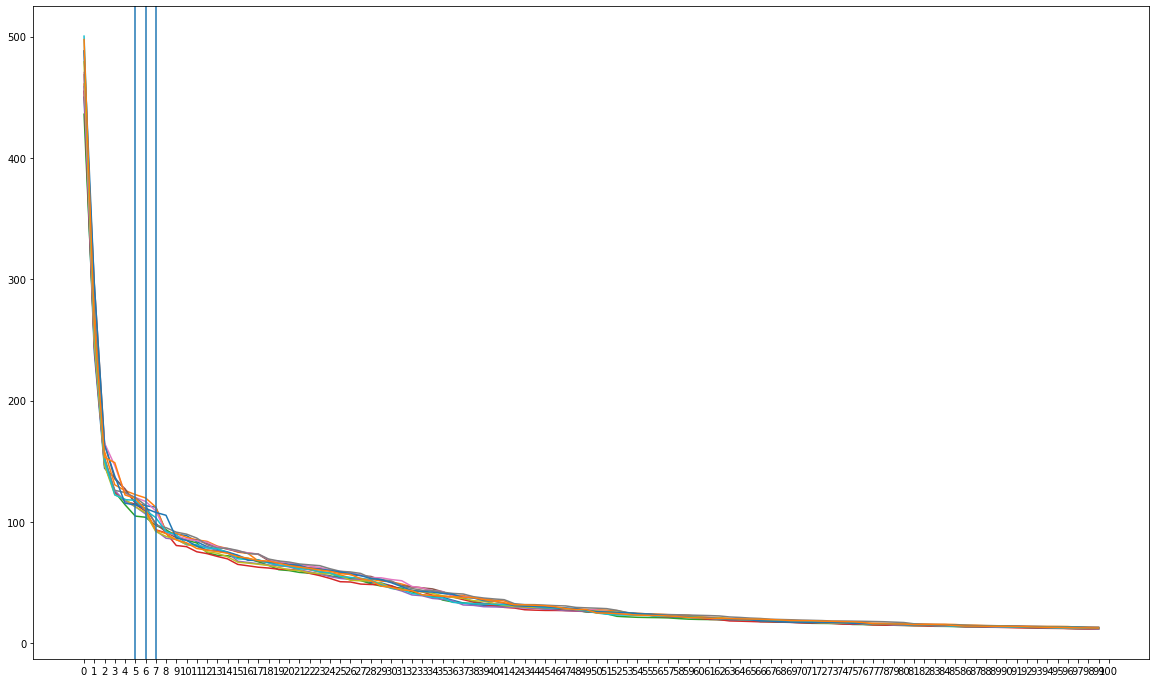

In [12]:
weeks = 12

plt.figure(figsize=(20,12))

for i in tqdm(range(weeks)):
    week_matrices = []
    for j in range(7):
        week_matrices.append(data_frame_list_uase[i*7+j])
    
    week_matrix = scipy.sparse.hstack(week_matrices)
    
        #user_week_matrix = week_matrix[:, k::10]
        
    u, s, v = scipy.sparse.linalg.svds(week_matrix,k=100)
    plt.plot(-np.sort(-s))
plt.xticks(np.arange(0, 101, 1.0))
plt.axvline(5)
plt.axvline(6)
plt.axvline(7)
plt.show()
        #Y = (v.transpose()*s**1/2).transpose()

So for all the matrices, somewhere around 6/7 eigenvalues we obtain an elbow. We'll use k=7 since this is still fast to compute but also allows us to capture a lot of the variance.

In [13]:
weeks = 12
Y_arrays = []

for i in range(weeks):
    week_matrices = []
    for j in range(7):
        week_matrices.append(data_frame_list_uase[i*7+j])
    
    week_matrix = scipy.sparse.hstack(week_matrices)
        
    u, s, v = scipy.sparse.linalg.svds(week_matrix.asfptype(),k=7)
    Y = pd.DataFrame((v.transpose()*s**0.5).transpose(),columns=(list(columns_sparse)*7))
    Y_arrays.append(Y)
    

In [14]:
u_count = len(columns_sparse)
anom = []

for i in tqdm(range(u_count)):
    
    normal_vals = list([] for x in range(7))
    
    for j in range(len(Y_arrays)-1):
        if j <=7:
            Y1 = Y_arrays[j].iloc[:, i::u_count]
            for k in range(7):
                vals_1 = Y1.iloc[:,k]
                normal_vals[k].append(list(vals_1))
                
        else:
            Y1 = Y_arrays[j].iloc[:, i::u_count]
            p_vals = []
            for k in range(7):
                vals_1 = Y1.iloc[:,k]
                vals_1 = [i for i in vals_1 if i != 0]
                comparison = normal_vals[k]
                comparison = [item for sublist in comparison for item in sublist]
                comparison = [i for i in comparison if i != 0]
                t,p = stats.ttest_ind(vals_1,comparison, equal_var=False)
                p_vals.append(p)
            p = scipy.stats.combine_pvalues(p_vals)
            if p[1] <= 0.05:
                anom.append((columns_sparse[i],j+1))
        

100%|██████████| 28815/28815 [03:14<00:00, 147.87it/s]


In [15]:
a,b=zip(*anom)
len(pd.Series(a).unique()), len(list(set(a) & set(rt_usernames)))

(1964, 20)

In [16]:
data_frame_list_uase_2 = []

start_time = datetime.datetime.now()

for i in tqdm(range(len(auth_start_days)-1)):

    data_frame_ind_2 = pd.DataFrame(index = list(authentication_data['DstDevice'].unique()))

    chunk = authentication_data[auth_start_days[i]:auth_start_days[i+1]]
    data_un_2 ={}
    for user in rt_usernames:
        dstdevice_data = chunk[chunk['UserName'] == user].groupby('DstDevice').size()
        data_un_2[user] = data_frame_ind_2.index.to_series().map(dstdevice_data.to_dict())

    data_frame_ind_2 = pd.DataFrame(data=data_un_2,index = list(authentication_data['DstDevice'].unique()))
    data_frame_ind_2 = data_frame_ind_2.notnull().astype('int')
    data_frame_ind_2 = data_frame_ind_2.fillna(0)
    A = np.array(data_frame_ind_2)
    sA = sparse.csr_matrix(A)
    data_frame_list_uase_2.append(sA)

100%|██████████| 90/90 [04:11<00:00,  2.80s/it]


In [17]:
weeks = 12
Y_arrays_2 = []

for i in range(weeks):
    week_matrices = []
    for j in range(7):
        week_matrices.append(data_frame_list_uase_2[i*7+j])
    
    week_matrix = scipy.sparse.hstack(week_matrices)
    
        #user_week_matrix = week_matrix[:, k::10]
        
    u, s, v = scipy.sparse.linalg.svds(week_matrix.asfptype(),k=7)
    Y = pd.DataFrame((v.transpose()*s**0.5).transpose(),columns=(list(set(rt_usernames))*7))
    Y_arrays_2.append(Y)
    

In [18]:
anom_2 = []

for i in tqdm(range(len(set(rt_usernames)))):
    for j in range(len(Y_arrays_2)-1):
        Y1 = Y_arrays_2[j].iloc[:, i::len(set(rt_usernames))]
        Y2 = Y_arrays_2[j+1].iloc[:, i::len(set(rt_usernames))]
        p_vals = []
        for k in range(7):
            vals_1 = Y1.iloc[:,k]
            vals_2 = Y2.iloc[:,k]
            if all(v == 0 for v in vals_1) or all(v == 0 for v in vals_2):
                   p = 1
            else:
                t,p = stats.ttest_ind(vals_1,vals_2, equal_var=False)
                p_vals.append(p)
        p = scipy.stats.combine_pvalues(p_vals)
        if p[1] <= 0.05:
            anom_2.append((columns_sparse[i],j+1))
        

100%|██████████| 95/95 [00:02<00:00, 42.28it/s]


unsuccessful implementation of anomalous outlier detection using DBSCAN

In [19]:
# from sklearn.cluster import DBSCAN
# from sklearn.cluster import OPTICS

# normal_anomalous_usernames = []
# for j in range(8):
#     for i in tqdm(range(7)):
#         #dbscan = DBSCAN(eps=0.025).fit((Y_arrays[j].iloc[0:2, :28815*(i+1)]).transpose())
#         Y = (Y_arrays[j].groupby(Y_arrays[j].columns.values, axis=1).agg(lambda x: x.values.tolist()).sum().apply(pd.Series).T).transpose()
#         dbscan = DBSCAN().fit(Y)
#         #plt.figure()
#         #plt.scatter(Y_arrays_2[0].loc[0][:95*(i+1)],Y_arrays_2[0].loc[1][:95*(i+1)],c=dbscan.labels_.astype(float))
#         #plt.figure()
#         for un in list(columns_sparse[np.where(dbscan.labels_ == -1)]):
#             if un not in normal_anomalous_usernames:
#                 normal_anomalous_usernames.append(un)

# anomalous_usernames = []
# for j in range(7,len(Y_arrays)):
#      for i in range(7):
#         #dbscan = DBSCAN(e=0.025).fit((Y_arrays[j].iloc[0:2, :28815*(i+1)]).transpose())
#         dbscan = DBSCAN(eps=0.025).fit((Y_arrays[j].groupby(Y_arrays[j].columns.values, axis=1).agg(lambda x: x.values.tolist()).sum().apply(pd.Series).T).transpose())
#         for un in list(columns_sparse[np.where(dbscan.labels_ == -1)]):
#             if un not in normal_anomalous_usernames:
#                 anomalous_usernames.append(un)

#### Anomaly Detection Using ASE principles - https://arxiv.org/pdf/2008.10055.pdf

In [43]:
u1, s1, v1 = scipy.sparse.linalg.svds(data_frame_list_uase[0],k=7)
u2, s2, v2 = scipy.sparse.linalg.svds(data_frame_list_uase[1],k=7)
Y1 = pd.DataFrame((v1.transpose()*s1**0.5).transpose(),columns=(list(set(columns_sparse))))
Y2 = pd.DataFrame((v2.transpose()*s2**0.5).transpose(),columns=(list(set(columns_sparse))))

nrm = scipy.linalg.norm(Y2-Y1,ord=2)

vertex_norm = []

for v in list(columns_sparse):
    nrm = scipy.linalg.norm(Y2[v]-Y1[v],ord=2)
    vertex_norm.append(nrm)
    
graph_mam =

In [120]:
def ASE_anom_finder(window_length):

    vertex_norm_tracker = []
    graph_norm_tracker = []

    graph_mam_tracker = []
    graph_range_tracker = []

    vertex_mam_tracker = []
    vertex_range_tracker = []

    for t in tqdm(range(len(data_frame_list_uase)-1)):
        u1, s1, v1 = scipy.sparse.linalg.svds(data_frame_list_uase[t],k=7)
        u2, s2, v2 = scipy.sparse.linalg.svds(data_frame_list_uase[t+1],k=7)
        Y1 = pd.DataFrame((v1.transpose()*s1**0.5).transpose(),columns=(list(set(columns_sparse))))
        Y2 = pd.DataFrame((v2.transpose()*s2**0.5).transpose(),columns=(list(set(columns_sparse))))

        nrm = scipy.linalg.norm(Y2-Y1,ord=2)
        graph_norm_tracker.append(nrm)

        vertex_norms = []
        for v in list(columns_sparse):
            nrm = scipy.linalg.norm(Y2[v]-Y1[v],ord=2)
            vertex_norms.append(nrm)

        vertex_norm_tracker.append(vertex_norms)

        if t >= window_length:
            graph_mam = np.sum(graph_norm_tracker[(t-window_length+1):t-1])/(window_length-1)
            graph_range = np.sum(np.linalg.norm(np.array(graph_norm_tracker[t-window_length+2:t-1])-np.array(graph_norm_tracker[t-window_length+1:t-2])))/(1.128*(window_length-2))
            graph_mam_tracker.append(graph_mam)
            graph_range_tracker.append(graph_range)

            vertex_mam_tracker_day = []
            vertex_range_tracker_day = []

            for j in range(len(list(columns_sparse))):
                vertex_mam = np.sum([vertex_norm_tracker[k][j] for k in range(t-window_length+1,t)])/(window_length-1)
                vertex_mam_tracker_day.append(vertex_mam)
                vertex_range = np.std([vertex_norm_tracker[k][j] for k in range(t-window_length+1,t)])/(window_length-1)
                vertex_range_tracker_day.append(vertex_range)
            vertex_mam_tracker.append(vertex_mam_tracker_day)
            vertex_range_tracker.append(vertex_range_tracker_day)

    day_anomalies = []

    for i,v in enumerate(list(columns_sparse)):
        y_v = np.array([vertex_norm_tracker[k][2] for k in range(len(vertex_norm_tracker))])
        ucl_v = np.array([vertex_mam_tracker[k][2] for k in range(len(vertex_mam_tracker))])+3*np.array([vertex_range_tracker[k][0] for k in range(len(vertex_range_tracker))])
        anomalies = [j for j,y in enumerate(y_v[window_length:]) if y > ucl_v[j]]
        day_anomalies.append((v,anomalies))
        
    return vertex_norm_tracker, graph_norm_tracker, graph_mam_tracker, graph_range_tracker, vertex_mam_tracker, vertex_range_tracker, day_anomalies

In [121]:
vertex_norm_tracker_7, graph_norm_tracker_7, graph_mam_tracker_7, graph_range_tracker_7, vertex_mam_tracker_7, vertex_range_tracker_7, day_anomalies_7 = ASE_anom_finder(7)
vertex_norm_tracker_14, graph_norm_tracker_14, graph_mam_tracker_14, graph_range_tracker_14, vertex_mam_tracker_14, vertex_range_tracker_14, day_anomalies_14 = ASE_anom_finder(14)
vertex_norm_tracker_3, graph_norm_tracker_3, graph_mam_tracker_3, graph_range_tracker_3, vertex_mam_tracker_3, vertex_range_tracker_3, day_anomalies_3 = ASE_anom_finder(3)
vertex_norm_tracker_2, graph_norm_tracker_2, graph_mam_tracker_2, graph_range_tracker_2, vertex_mam_tracker_2, vertex_range_tracker_2, day_anomalies_2 = ASE_anom_finder(2)

 36%|███▌      | 32/89 [02:39<04:43,  4.98s/it]


KeyboardInterrupt: 

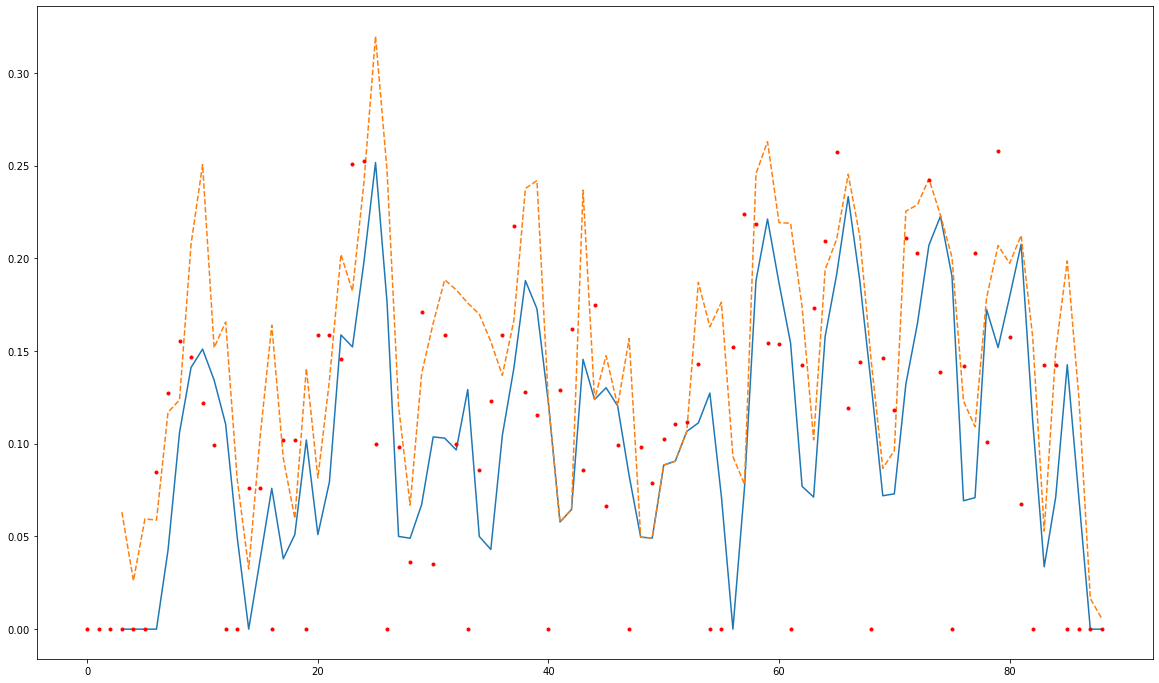

In [93]:
plt.figure(figsize = (20,12))  
plt.plot(np.arange(window_length,len(data_frame_list_uase)-1),[vertex_mam_tracker[k][2] for k in range(len(vertex_mam_tracker))])
plt.plot(np.arange(window_length,len(data_frame_list_uase)-1),np.array([vertex_mam_tracker[k][2] for k in range(len(vertex_mam_tracker))])+3*np.array([vertex_range_tracker[k][0] for k in range(len(vertex_range_tracker))]),'--')
plt.plot([vertex_norm_tracker[k][2] for k in range(len(vertex_norm_tracker))],'r.')

#### Neural Network

We make the assumption that traffic from the red team usernames during the 57-82 day period is always anomalous whereas the traffic between any other time periods and non-red teeam uesrnames is not.

In [21]:
def feature_generation_supervised(user,n,anom):
    
    feat_dict = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
            
            hour = j
            data = chunks[j]
            
            if 57 <= i+1 <= 82 and anom=True:
                anombool = 1
            else:
                anombool = 0

            authents = len(data[data['UserName'] == user])
            failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
            srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
            dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
            uniquepairs = len(data.groupby(['SrcDevice','DstDevice']).size())
            feat_dict[i*n + j] = [user,srcunique,dstunique,authents,failures,anombool]
            #feat_dict[i*n + j] = [day,hour,srcunique,dstunique,uniquepairs,authents,failures]
                
    df = pd.DataFrame(data=feat_dict,index =  ['UserName','SrcUnique','DstUnique','Authentications','Failures','Anomaly'])
    #df = pd.DataFrame(data=feat_dict,index =  ['Day','Hour','SrcUnique','DstUnique','UniquePairs','Authentications','Failures'])
    df = df.transpose()
    df = df.fillna(0)
    
    return df

In [74]:
username_sample = list(pd.Series(rt_usernames).unique()) + random.sample(non_rt_users,400)
data = []
for user in tqdm(username_sample):
    if user in rt_usernames:
        anom = 1
    else:
        anom = 0
    df = feature_generation_supervised(user,24,anom)
    data.append(df)



  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 1/495 [00:15<2:07:55, 15.54s/it]

  0%|          | 2/495 [00:30<2:06:02, 15.34s/it]

  1%|          | 3/495 [00:45<2:04:22, 15.17s/it]

  1%|          | 4/495 [01:00<2:03:29, 15.09s/it]

  1%|          | 5/495 [01:15<2:02:45, 15.03s/it]

  1%|          | 6/495 [01:30<2:02:46, 15.06s/it]

  1%|▏         | 7/495 [01:45<2:02:08, 15.02s/it]

  2%|▏         | 8/495 [02:00<2:01:36, 14.98s/it]

  2%|▏         | 9/495 [02:15<2:01:17, 14.97s/it]

  2%|▏         | 10/495 [02:30<2:00:55, 14.96s/it]

  2%|▏         | 11/495 [02:45<2:00:55, 14.99s/it]

  2%|▏         | 12/495 [02:59<1:59:22, 14.83s/it]

  3%|▎         | 13/495 [03:14<1:59:16, 14.85s/it]

  3%|▎         | 14/495 [03:29<1:59:10, 14.87s/it]

  3%|▎         | 15/495 [03:44<1:58:59, 14.87s/it]

  3%|▎         | 16/495 [03:59<1:59:03, 14.91s/it]

  3%|▎         | 17/495 [04:14<1:58:49, 14.92s/it]

  4%|▎         | 18/495 [04:29<1:58:45, 14.94s/it]

  4%|▍         | 19/495 [04:44

In [79]:
nn_data = pd.concat(data)
nn_data.to_csv('nn_supervised data.gz', compression='gzip')
X_train, X_test, y_train, y_test = train_test_split(nn_data[['UserName','SrcUnique','DstUnique','Authentications','Failures']], nn_data['Anomaly'], test_size=0.1, random_state=42)
X_train_un_list = list(X_train['UserName'])
X_test_un_list = list(X_test['UserName'])
X_train = X_train.drop('UserName',axis=1)
X_test = X_test.drop('UserName',axis=1)

In [76]:
def nn_anomaly_finder(x_train,x_test,y_train,y_test,train_user,test_user,n,BATCH_SIZE=256, EPOCHS=1000):
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train)
    x_train = pipeline.transform(x_train)
    x_test = pipeline.transform(x_test)
    
    # define neural network parameters
    input_dim = x_train.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the nn
    neural_network =Sequential([

        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')

    ])

    # compile the autoencoder
    neural_network.compile(optimizer="adam", 
                        loss='binary_crossentropy',
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = neural_network.fit(
        x_train, y_train,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = neural_network.predict(x_test)
    Y_pred = x_test_pred.argmax(axis=1)
    test_loss, test_acc = neural_network.evaluate(X_test, y_test)
    print(test_acc)
    
    anomalies = x_test[np.where(x_test_pred == 1)]
    #anomaly_idx = anomalies[0]
    
    #frame = []
    #for i in range(len(anomaly_idx)):
    #    user = test_user[anomaly_idx[i]]
    #    anomaly = nn_orig_finder(user,n,anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
    #    if len(anomaly) == 0:
    #        pass
    #    else:
    #        frame.append(anomaly)
    #    
    #if len(frame) != 0:
    #    anomaly_df = pd.concat(frame)
    #    return anomaly_df,1,history.history["val_loss"]
    #else:
    #    print('No anomalies found.')
    #    return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]
    return Y_pred

In [77]:
Y_pred = nn_anomaly_finder(X_train,X_test,y_train,y_test,X_train_un_list,X_test_un_list,24,BATCH_SIZE=256, EPOCHS=1000)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
3342/3342 [==============================] - 2s 525us/step - loss: 0.5484 - acc: 0.7307
0.7306958436965942


In [78]:
pd.DataFrame(Y_pred).groupby(0).size()

0
0    106920
dtype: int64